# Data prep

In [ ]:
import os
import zipfile
import urllib.request

url = 'https://zenodo.org/records/7224690/files/FruQ-multi.zip?download=1'

download_directory = '/content/'

filename = 'FruQ.zip'

os.makedirs(download_directory, exist_ok=True)

urllib.request.urlretrieve(url, os.path.join(download_directory, filename))

with zipfile.ZipFile(os.path.join(download_directory, filename), 'r') as zip_ref:
    zip_ref.extractall(download_directory)

In [ ]:
import os
import shutil

os.rename("FruQ-multi", "FruQ")

for directory in os.listdir("FruQ"):
    for d in os.listdir("FruQ/" + directory):
        os.rename("FruQ/" + directory + "/" + d, "FruQ/" + directory + "/" + directory + "_" + d)
        shutil.move("FruQ/" + directory + "/" + directory + "_" + d, "FruQ")
    os.rmdir("FruQ/" + directory)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import keras
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 360
IMAGE_WIDTH = 640
CHANNELS = 3
EPOCHS = 12

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "FruQ",
    shuffle = True,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE
)

Found 9370 files belonging to 32 classes.


In [ ]:
class_names = dataset.class_names
class_names

['BananaDB_Good',
 'BananaDB_Rotten',
 'BananaDB_mild',
 'CucumberQ_Fresh',
 'CucumberQ_Mild',
 'CucumberQ_Rotten',
 'GrapeQ_Good',
 'GrapeQ_Mild',
 'GrapeQ_Rotten',
 'KakiQ_Good',
 'KakiQ_Mild',
 'KakiQ_Rotten',
 'PapayaQ_Good',
 'PapayaQ_Mild',
 'PapayaQ_Rotten',
 'PeachQ_Good',
 'PeachQ_Mild',
 'PeachQ_Rotten',
 'PearQ_Good',
 'PearQ_Mild',
 'PearQ_Rotten',
 'PepperQ_Good',
 'PepperQ_Mild',
 'PepperQ_Rotten',
 'StrawberryQ_Mild',
 'StrawberryQ_Rotten',
 'WatermeloQ_Good',
 'WatermeloQ_Mild',
 'WatermeloQ_Rotten',
 'tomatoQ_Good',
 'tomatoQ_Mild',
 'tomatoQ_Rotten']

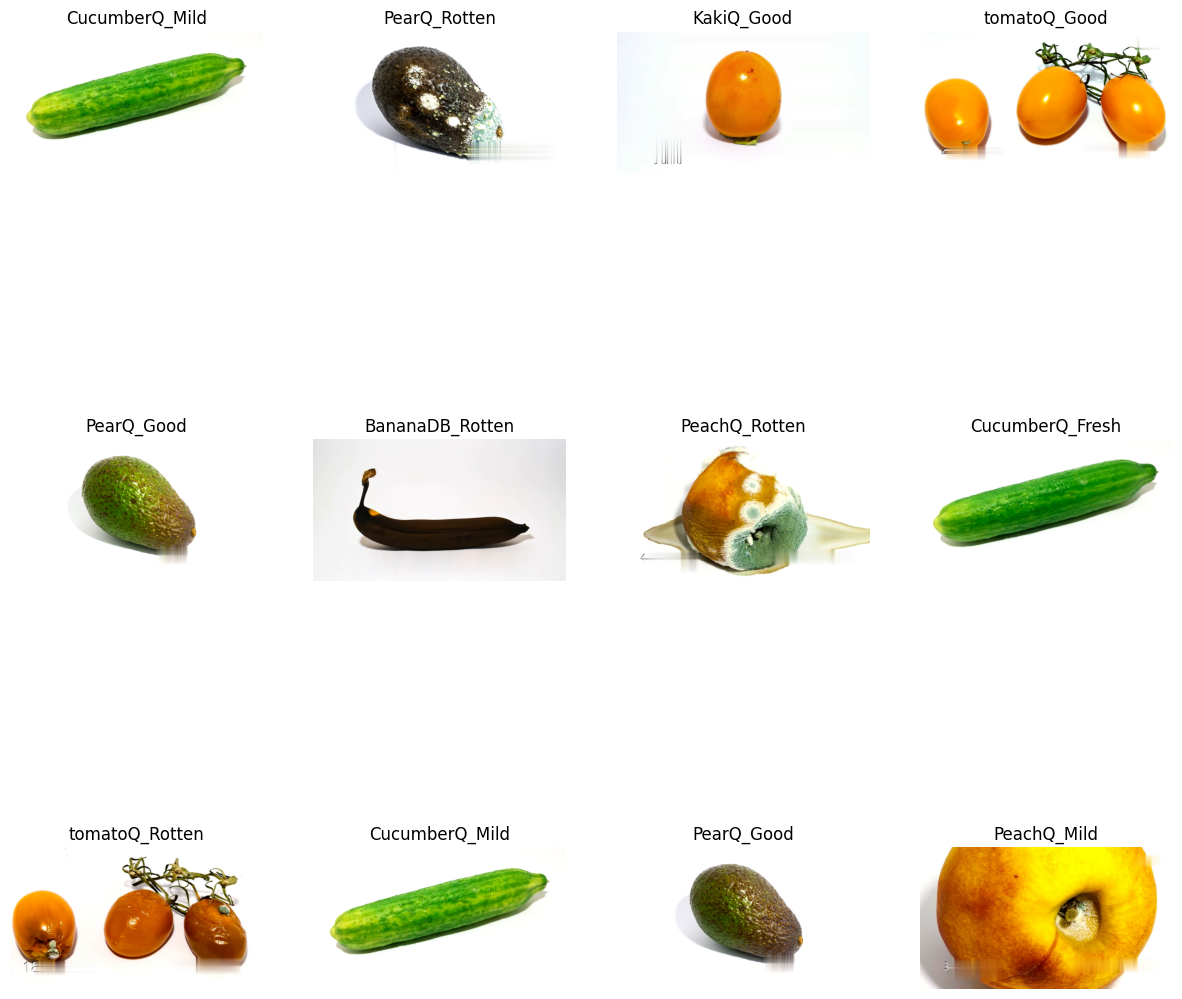

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Training

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 360, 640, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 358, 638, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 179, 319, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 177, 317, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 88, 158, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 86, 156, 64)        

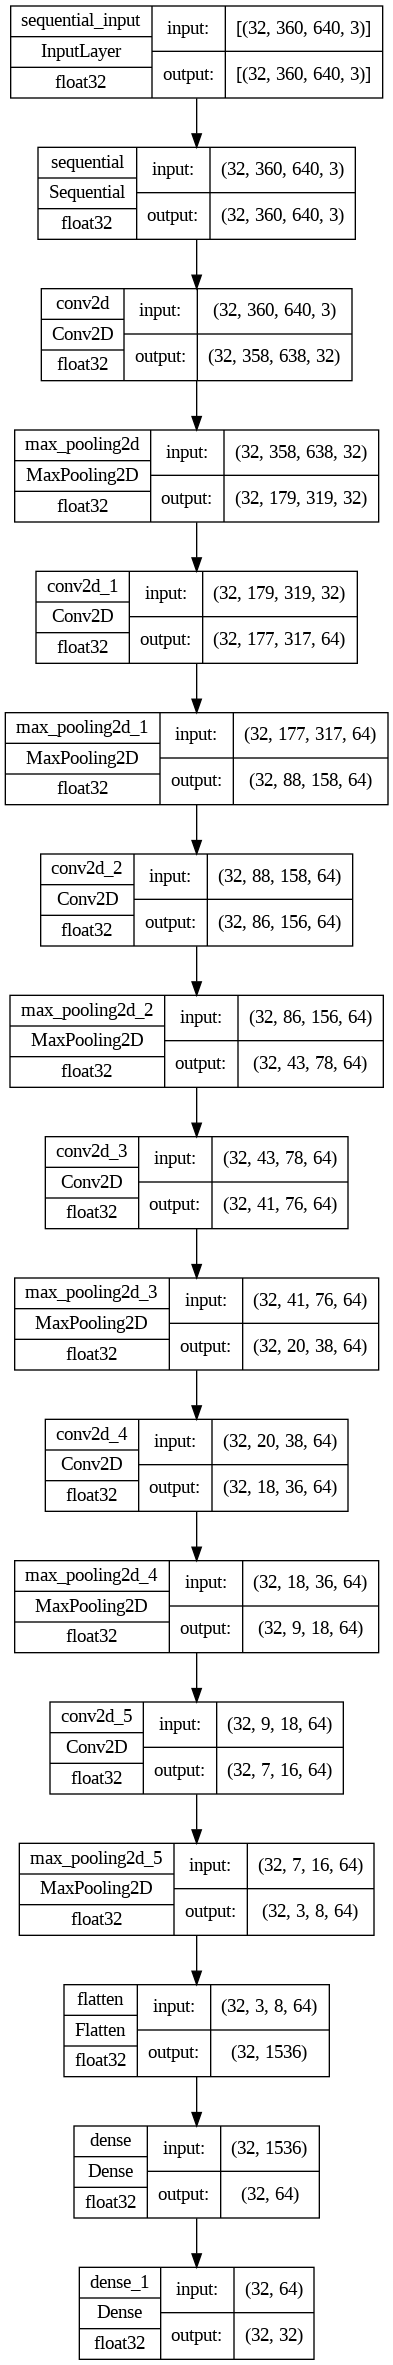

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, show_dtype=True)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/12
234/234 [==============================] - 316s 1s/step - loss: 1.6845 - accuracy: 0.4928 - val_loss: 0.4517 - val_accuracy: 0.8168
Epoch 2/12
234/234 [==============================] - 233s 995ms/step - loss: 0.3909 - accuracy: 0.8595 - val_loss: 0.2070 - val_accuracy: 0.9192
Epoch 3/12
234/234 [==============================] - 231s 989ms/step - loss: 0.2230 - accuracy: 0.9196 - val_loss: 0.1716 - val_accuracy: 0.9321
Epoch 4/12
234/234 [==============================] - 231s 986ms/step - loss: 0.1787 - accuracy: 0.9378 - val_loss: 0.1484 - val_accuracy: 0.9450
Epoch 5/12
234/234 [==============================] - 232s 989ms/step - loss: 0.1444 - accuracy: 0.9434 - val_loss: 0.1647 - val_accuracy: 0.9181
Epoch 6/12
234/234 [==============================] - 230s 981ms/step - loss: 0.1335 - accuracy: 0.9523 - val_loss: 0.1275 - val_accuracy: 0.9364
Epoch 7/12
234/234 [==============================] - 231s 986ms/step - loss: 0.1120 - accuracy: 0.9577 - val_loss: 0.1458 - va

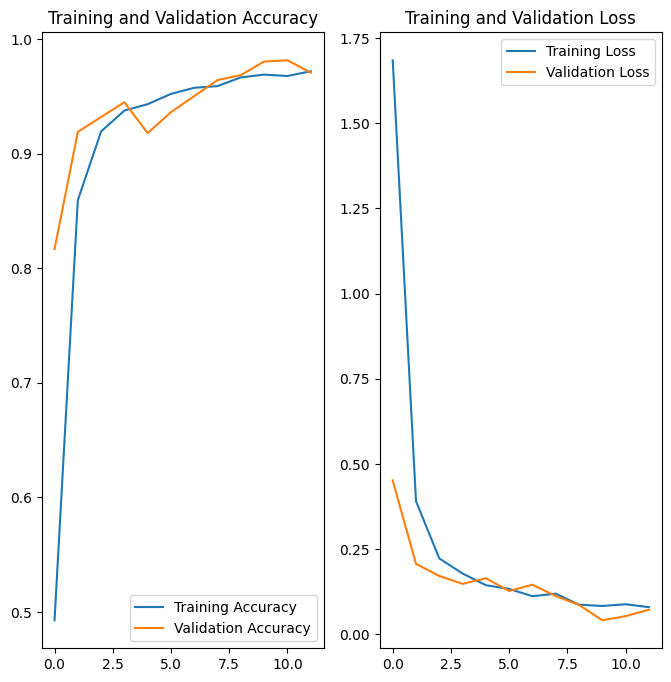

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation

In [ ]:
scores = model.evaluate(test_ds)

30/30 [==============================] - 49s 42ms/step - loss: 0.0748 - accuracy: 0.9729


In [ ]:
scores

[0.0748296007514, 0.9729166626930237]

In [ ]:
import pickle

model_file = open('FruQ_model.pkl', 'wb')

pickle.dump(model, model_file)

model_file.close()

In [ ]:
import pickle

model_file = open('FruQ_model.pkl', 'rb')

model = pickle.load(model_file)

model_file.close()

first image to predict
actual label: KakiQ_Mild
1/1 [==============================] - 0s 257ms/step
predicted label: KakiQ_Mild


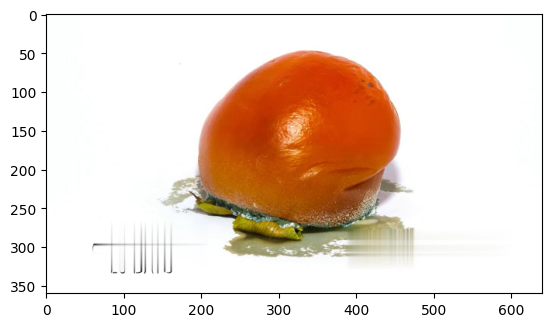

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 21ms/step


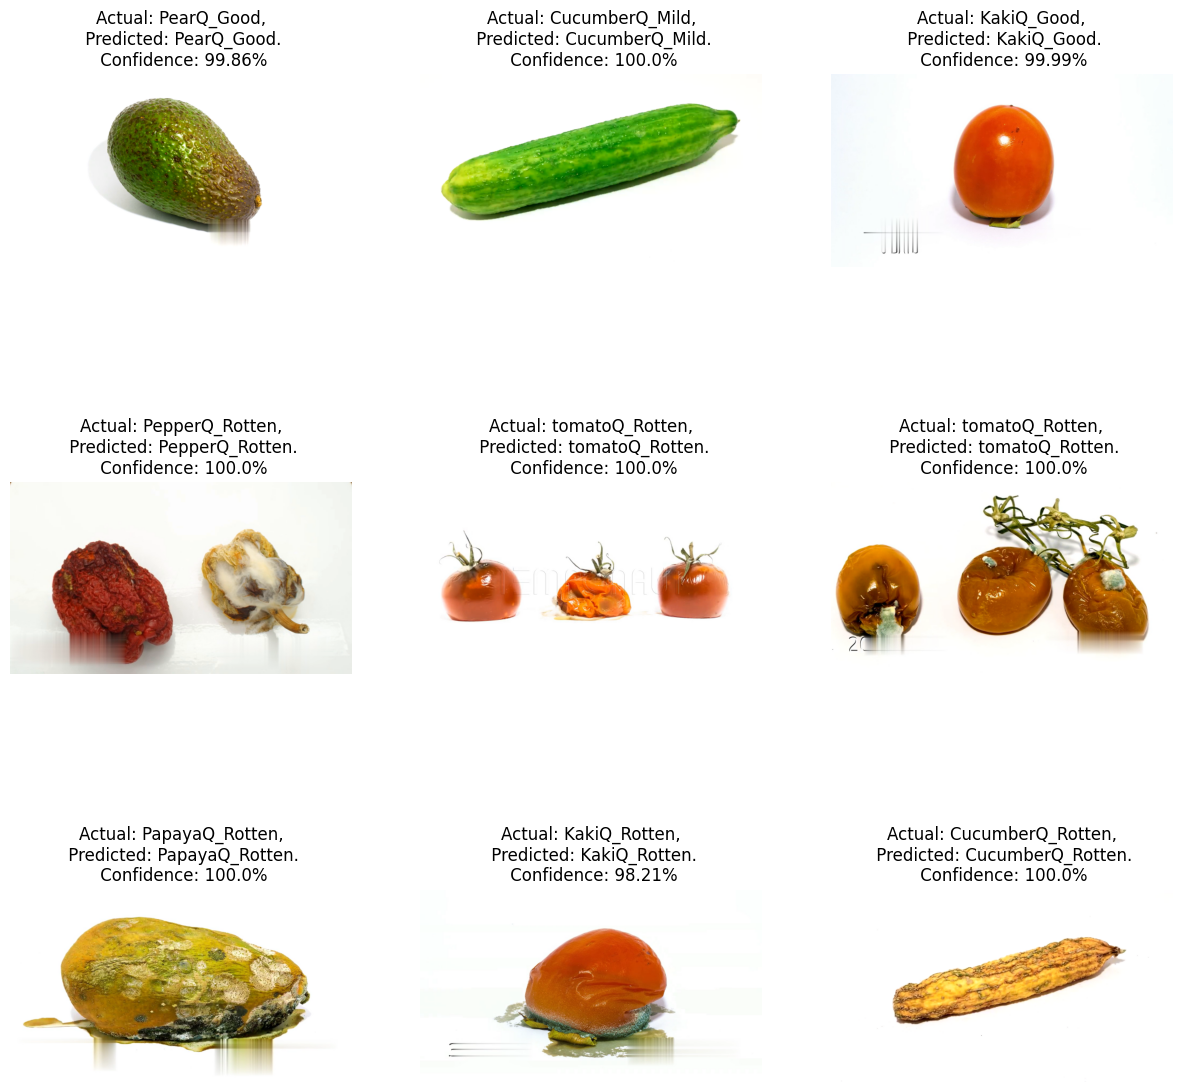

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")